# A Brief Introduction to Spatial Data Science

- Martin Fleischmann
- City Transitions: Society and the Spatial and Temporal Dimensions of Change
- Saarland University (Saarbrücken, Germany), September 13th 2024

## Outline

- Spatial weights
- Spatial autocorrelation
- Spatial clustering

## Spatial weights in PySAL

In this part, you will be learning the ins and outs of one of the key
pieces in spatial analysis: spatial weights matrices. These are
structured sets of numbers that formalise geographical relationships
between the observations in a dataset. Essentially, a spatial weights
matrix of a given geography is a positive definite matrix of dimensions
$N$ by $N$, where $N$ is the total number of observations:

$$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0
\end{array} \right)
$$

where each cell $w_{ij}$ contains a value that represents the degree of
spatial contact or interaction between observations $i$ and $j$. A
fundamental concept in this context is that of *neighbour* and
*neighbourhood*. By convention, elements in the diagonal ($w_{ii}$) are
set to zero. A *neighbour* of a given observation $i$ is another
observation with which $i$ has some degree of connection. In terms of
$W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this
logic, the neighbourhood of $i$ will be the set of observations in the
system with which it has a certain connection or those observations with
a weight greater than zero.

There are several ways to create such matrices and many more to
transform them so they contain an accurate representation that aligns
with the way you understand spatial interactions between the elements of
a system. This session will introduce the most commonly used ones and
show how to compute them with `PySAL`.

In [ ]:
import matplotlib.pyplot as plt
import esda
import contextily
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns

from libpysal import graph
from sklearn import cluster

## Data

For this tutorial, you will use a dataset of Basic Settlement Units
(ZSJ) in Prague for 2021. The table is available as part of this course,
so it can be accessed remotely through the web. If you want to see how
the table was created, a notebook is available
[here](../data/prague_zsj_2021/preprocessing.ipynb).

To make things easier, you will read data from a file posted online so,
for now, you do not need to download any dataset:

In [ ]:
prague = gpd.read_file(
    "https://martinfleischmann.net/sds/spatial_graphs/data/zsj_prague_2021.gpkg"
)
prague = prague.set_index("NAZ_ZSJ")
prague.explore()

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/spatial_graphs/data/zsj_prague_2021.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> prague = gpd.read_file(
>     "zsj_prague_2021.gpkg",
> )
> ```

## Building spatial weights in `PySAL`

### Contiguity

Contiguity weights matrices define spatial connections through the
existence of shared boundaries. This makes it directly suitable to use
with polygons: if two polygons share boundaries to some degree, they
will be labelled as neighbours under these kinds of weights. Exactly how
much they need to share is what differentiates the two approaches we
will learn: Queen and Rook.

#### Queen

Under the Queen criteria, two observations only need to share a vertex
(a single point) of their boundaries to be considered neighbours.
Constructing a weights matrix under these principles can be done by
running:

In [ ]:
queen = graph.Graph.build_contiguity(prague, rook=False)
queen

The command above creates an object `queen` of the class `Graph`. This
is the format in which spatial weights matrices are stored in `PySAL`.
By default, the weights builder (`Graph.build_contiguity(`) will use the
index of the table, which is useful so you can keep everything in line
easily.

> **New `Graph` and old `W`**
>
> The `graph` module of `libpysal` is an implementation of spatial
> weights matrices released in September 2023. In the older resources,
> you will find the `weights` module and the `W` class instead. `Graph`
> will eventually replace `W`. Their API is similar, but there are some
> differences. Pay attention to the documentation when porting code from
> `weights`-based resources to `graph`-based implementation. Or use
> `Graph.to_W()` and `Graph.from_W()` to convert one to the other.

A `Graph` object can be queried to find out about the contiguity
relations it contains. For example, if you would like to know who is a
neighbour of observation `Albertov`:

In [ ]:
queen['Albertov']

This returns a `pandas.Series` containing each neighbour’s ID codes as
an index, with the weights assigned as values. Since you are looking at
a raw Queen contiguity matrix, every neighbour gets a weight of one. If
you want to access the weight of a specific neighbour, `Zderaz` for
example, you can do recursive querying:

In [ ]:
queen['Albertov']['Zderaz']

All of these relations can be easily visualised using `Graph.explore()`
method you know from GeoPandas.

In [ ]:
m = prague.explore()
queen.explore(
    prague, m=m, edge_kws=dict(style_kwds=dict(weight=1)), nodes=False
)

> **Static plots**
>
> Similarly to `GeoDataFrame`, `Graph` can also be visualised as a
> static plot, using the `Graph.plot()` method working analogously to
> `Graph.explore()`.
>
> ``` python
> ax = queen.plot(prague, nodes=False, edge_kws={"linewidth": .5})
> contextily.add_basemap(ax=ax, crs=prague.crs, source="CartoDB Positron")
> ax.set_axis_off()
> ```
>
> <figure>
> 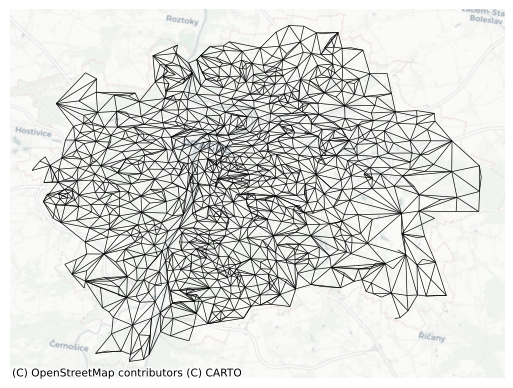 alt="Static plot of Queen contiguity" />
> <figcaption aria-hidden="true">Static plot of Queen
> contiguity</figcaption>
> </figure>

Once created, `Graph` objects can provide much information about the
matrix beyond the basic attributes one would expect. You have direct
access to the number of neighbours each observation has via the
attribute `cardinalities`. For example, to find out how many neighbours
observation `E01006524` has:

In [ ]:
queen.cardinalities['Albertov']

Since `cardinalities` is a `Series`, you can use all of the `pandas`
functionality you know:

In [ ]:
queen.cardinalities.head()

You can easily compute the mean number of neighbours.

In [ ]:
queen.cardinalities.mean()

Or learn about the maximum number of neighbours a single geometry has.

In [ ]:
queen.cardinalities.max()

This also allows access to quick plotting, which comes in very handy in
getting an overview of the size of neighbourhoods in general:

In [ ]:
sns.displot(queen.cardinalities, bins=14, kde=True)

The figure above shows how most observations have around five
neighbours, but there is some variation around it. The distribution also
seems to follow nearly a symmetric form, where deviations from the
average occur both in higher and lower values almost evenly, with a
minor tail towards higher values.

Some additional information about the spatial relationships contained in
the matrix is also easily available from a `Graph` object. You can ask
about the number of observations (geometries) encoded in the graph:

In [ ]:
queen.n

Or learn which geometries are *isolates*, the observations with no
neighbours (think about islands).

In [ ]:
queen.isolates

A nice summary of these properties is available using the `summary()`
method.

In [ ]:
queen.summary()

Spatial weight matrices can be explored visually in other ways. For
example, you can pick an observation and visualise it in the context of
its neighbourhood. The following plot does exactly that by zooming into
the surroundings of ZSJ `Albertov` and displaying its polygon as well as
those of its neighbours together with a relevant portion of the `Graph`:

In [ ]:
m = prague.loc[queen["Albertov"].index].explore(color="#25b497")
prague.loc[["Albertov"]].explore(m=m, color="#fa94a5")
queen.explore(prague, m=m, focal="Albertov")

#### Rook

Rook contiguity is similar to and, in many ways, superseded by Queen
contiguity. However, since it sometimes comes up in the literature, it
is useful to know about it. The main idea is the same: two observations
are neighbours if they share some of their boundary lines. However, in
the Rook case, it is not enough to share only one point. It needs to be
at least a segment of their boundary. In most applied cases, these
differences usually boil down to how the geocoding was done, but in some
cases, such as when you use raster data or grids, this approach can
differ more substantively, and it thus makes more sense.

From a technical point of view, constructing a Rook matrix is very
similar:

In [ ]:
rook = graph.Graph.build_contiguity(prague, rook=True)
rook

The output is of the same type as before, a `Graph` object that can be
queried and used in very much the same way as any other one.

#### Bishop

In a similar sense, you may want to create Bishop contiguity - consider
two geometries neighbouring if they share only one vertex. There’s no
constructor for that but you can derive Bishop contiguity from Queen and
Rook as Queen contains both shared vertex and shared edge relations. You
can, therefore, subtract one from the other to get Bishop contiguity:

In [ ]:
bishop = queen.difference(rook)
bishop

See the remaining edges:

In [ ]:
ax = bishop.plot(prague, nodes=False, edge_kws={"linewidth": .5})
contextily.add_basemap(ax=ax, crs=prague.crs, source="CartoDB Positron")
ax.set_axis_off()

Only a small fraction of Queen neighbours are not Rook neighbors at the
same time (represented by the number of edges here), but there are some.

### Distance

Distance-based matrices assign the weight to each pair of observations
as a function of how far from each other they are. How this is
translated into an actual weight varies across types and variants, but
they all share that the ultimate reason why two observations are
assigned some weight is due to the distance between them.

#### K-Nearest Neighbors

One approach to define weights is to take the distances between a given
observation and the rest of the set, rank them, and consider as
neighbours the $k$ closest ones. That is exactly what the $k$-nearest
neighbours (KNN) criterium does.

To calculate KNN weights, you can use a similar function as before and
derive them from a `GeoDataFrame`:

In [ ]:
prague["centroid"] = prague.centroid
prague = prague.set_geometry("centroid")
knn5 = graph.Graph.build_knn(prague, k=5)
knn5

See the resulting graph visually:

In [ ]:
ax = knn5.plot(prague, nodes=False, edge_kws={"linewidth": .5})
contextily.add_basemap(ax=ax, crs=prague.crs, source="CartoDB Positron")
ax.set_axis_off()

Note how you need to specify the number of nearest neighbours you want
to consider with the argument `k`. Since it is a polygon `GeoDataFrame`
that you are passing, you need to compute the centroids to derive
distances between observations. Alternatively, you can provide the
points in the form of an array, skipping this way the dependency of a
file on disk:

In [ ]:
pts = pd.DataFrame(
    {"X": prague.geometry.x, "Y": prague.geometry.y}
).values
knn5_from_pts = graph.Graph.build_knn(pts, k=5)

#### Distance band

Another approach to building distance-based spatial weights matrices is
to draw a circle of certain radius and consider neighbour every
observation that falls within the circle. The technique has two main
variations: binary and continuous. In the former one, every neighbour is
given a weight of one, while in the second one, the weights can be
further tweaked by the distance to the observation of interest.

To compute binary distance matrices in `PySAL`, you can use the
following command:

In [ ]:
dist1kmB = graph.Graph.build_distance_band(prague, 1000)
dist1kmB

This creates a binary matrix that considers neighbors of an observation
every polygon whose centroid is closer than 1,000 metres (1 km) to the
centroid of such observation. Check, for example, the neighbourhood of
polygon `Albertov`:

In [ ]:
dist1kmB['Albertov']

Note that the units in which you specify the distance directly depend on
the CRS in which the spatial data are projected, and this has nothing to
do with the weights building but it can affect it significantly. Recall
how you can check the CRS of a `GeoDataFrame`:

In [ ]:
prague.crs

In this case, you can see the unit is expressed in metres (`m`). Hence
you set the threshold to 1,000 for a circle of 1km radius. The whole
graph looks like this:

In [ ]:
ax = dist1kmB.plot(prague, nodes=False, edge_kws={"linewidth": .5})
contextily.add_basemap(ax=ax, crs=prague.crs, source="CartoDB Positron")
ax.set_axis_off()

### Block weights

Block weights connect every observation in a dataset that belongs to the
same category in a list provided ex-ante. Usually, this list will have
some relation to geography and the location of the observations but,
technically speaking, all one needs to create block weights is a list of
memberships. In this class of weights, neighbouring observations, those
in the same group, are assigned a weight of one, and the rest receive a
weight of zero.

In this example, you will build a spatial weights matrix that connects
every ZSJ with all the other ones in the same KU. See how the KU code is
expressed for every ZSJ:

In [ ]:
prague.head()

To build a block spatial weights matrix that connects as neighbours all
the ZSJ in the same KU, you only require the mapping of codes. Using
`PySAL`, this is a one-line task:

In [ ]:
block = graph.Graph.build_block_contiguity(prague['NAZ_KU'])
block

If you query for the neighbors of observation by its name, it will work
as usual:

In [ ]:
block['Albertov']

Notice the resulting blocks are clearly visible when you visualise the
graph:

In [ ]:
ax = block.plot(prague, nodes=False, edge_kws={"linewidth": .5})
contextily.add_basemap(ax=ax, crs=prague.crs, source="CartoDB Positron")
ax.set_axis_off()

## Using graph to aggregate variables

A typical use of a graph is a description of the distribution of values
within the neighborhood of each geometry. This can be done either solely
based on the neighborhood definition, ignoring the actual weight, or as
a weighted operation.

### Describe

The first option is implemented within the `describe()` method, which
returns a statistical description of distribution of a given variable
within each neighborhood.

For this illustration, you will use the area of each polygon as the
variable of interest. And to make things a bit nicer later on, you will
keep the log of the area instead of the raw measurement. Hence, let’s
create a column for it:

In [ ]:
prague = prague.set_geometry("geometry")
prague["area"] = np.log(prague.area)

In [ ]:
area_description = queen.describe(
    prague["area"],
    statistics=["mean", "median", "min", "max", "std"],
)
area_description.head()

The table can be directly assigned to the `prague` DataFrame, if needed.

In [ ]:
prague = prague.join(area_description)
prague.head()

Compare a subset visually on a map. You can create a subplot with 4 axes
and loop over the selected columns to do that efficiently.

In [ ]:
columns = ["area", "mean", "std", "max"]

fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs = axs.flatten()
for column, ax in zip(columns, axs):
    prague.plot(column, ax=ax, legend=True, cmap="YlGnBu")
    ax.set_axis_off()
    ax.set_title(column)

## Spatial Lag

If you need to use the weight, you are looking for the so-called
*spatial lag*. The spatial lag of a given variable is the product of a
spatial weight matrix and the variable itself:

$$
Y_{sl} = W Y
$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that
the product of a matrix and a vector equals the sum of a row by column
element multiplication for the resulting value of a given row. In terms
of the spatial lag:

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

If you are using row-standardized weights, $w_{ij}$ becomes a proportion
between zero and one, and $y_{sl-i}$ can be seen as the mean value of
$Y$ in the neighborhood of $i$, the same you would get with
`describe()`.

The spatial lag is a key element of many spatial analysis techniques, as
you will see later on and, as such, it is fully supported in `PySAL`. To
compute the spatial lag of a given variable, `area`, for example:

In [ ]:
queen_lag = queen.lag(prague["area"])
queen_lag[:5]

Line 1 contains the actual computation, which is highly optimised in
`PySAL`. Note that, despite passing in a `pd.Series` object, the output
is a `numpy` array. This however, can be added directly to the table
`prague`:

In [ ]:
prague['area_lag'] = queen_lag

### Categorical lag

If you have categorical data, you can use the categorical lag, which
returns the most common category within the neighbors. You can try with
the KU name.

In [ ]:
categorical_lag = queen.lag(prague["NAZ_KU"], ties="tryself")
categorical_lag[:5]

Note that when there is a tie, i.e., no category is the most common,
`lag()` will raise an error by default. You can let it resolve ties
either by including the value from the focal observation to break the
tie or by picking the one randomly (`ties="random"`).

# Spatial autocorrelation

In the last section, you learned how to encode spatial relationships
between geometries into weights matrices represented by `Graph` objects
and started touching on spatial autocorrelation with spatial lag and
Moran plot. This section explores spatial autocorrelation further in its
global and local variants.

Spatial autocorrelation has to do with the degree to which the
similarity in values between observations in a dataset is related to the
similarity in locations of such observations. Not completely unlike the
traditional correlation between two variables -which informs us about
how the values in one variable change as a function of those in the
other- and analogous to its time-series counterpart -which relates the
value of a variable at a given point in time with those in previous
periods-, spatial autocorrelation relates the value of the variable of
interest in a given location with values of the same variable in
surrounding locations.

A key idea in this context is that of spatial randomness: a situation in
which the location of observation gives no information whatsoever about
its value. In other words, a variable is spatially random if it is
distributed following no discernible pattern over space. Spatial
autocorrelation can thus be formally defined as the “absence of spatial
randomness”, which gives room for two main classes of autocorrelation,
similar to the traditional case: *positive* spatial autocorrelation,
when similar values tend to group together in similar locations; and
*negative* spatial autocorrelation, in cases where similar values tend
to be dispersed and further apart from each other.

In this session, you will learn how to explore spatial autocorrelation
in a given dataset, interrogating the data about its presence, nature,
and strength. To do this, you will use a set of tools collectively known
as Exploratory Spatial Data Analysis (ESDA), specifically designed for
this purpose. The range of ESDA methods is very wide and spans from less
sophisticated approaches like choropleths and general table querying to
more advanced and robust methodologies that include statistical
inference and explicit recognition of the geographical dimension of the
data. The purpose of this session is to dip your toes into the latter
group.

ESDA techniques are usually divided into two main groups: tools to
analyse *global*, and *local* spatial autocorrelation. The former
considers the overall trend that the location of values follows and
makes possible statements about the degree of *clustering* in the
dataset. *Do values generally follow a particular pattern in their
geographical distribution*? *Are similar values closer to other similar
values than you would expect from pure chance?* These are some of the
questions that tools for global spatial autocorrelation allow to answer.
You will practice with global spatial autocorrelation on the Join Counts
statistic and Moran’s $I$ statistic.

Tools for *local* spatial autocorrelation instead focus on spatial
instability: the departure of parts of a map from the general trend. The
idea here is that, even though there is a given trend for the data in
terms of the nature and strength of spatial association, some particular
areas can diverge quite substantially from the general pattern.
Regardless of the overall degree of concentration in the values, you can
observe pockets of unusually high (low) values close to other high (low)
values in what you will call hot (cold) spots. Additionally, it is also
possible to observe some high (low) values surrounded by low (high)
values, and you will name these “spatial outliers”. The main technique
you will review in this session to explore local spatial autocorrelation
is the Local Indicators of Spatial Association (LISA).

## Data

For this session, you will look at the election data. In particular, the
results of the second round of the presidential elections in Czechia in
2023, between Petr Pavel and Andrej Babiš, on a level of municipalities.
Each polygon has a percentage of votes for either of the candidates
attached, as well as some additional information. Election data are
provided by the [Czech Statistical Office](https://www.volby.cz), and
geometries are retrieved from [ČÚZK](https://www.cuzk.cz). The dataset
is preprocessed for the purpose of this course. If you want to see how
the table was created, a notebook is available
[here](../data/cz_elections_2023/preprocessing.ipynb).

To make things easier, you will read data from a file posted online, so
you do not need to download any dataset:

In [ ]:
elections = gpd.read_file(
    "https://martinfleischmann.net/sds/autocorrelation/data/cz_elections_2023.gpkg"
)
elections = elections.set_index("name")
elections.explore(
    "PetrPavel",
    cmap="coolwarm",
    vmin=0,
    vmax=100,
    prefer_canvas=True,
    tiles="CartoDB Positron",
)

## Spatial weights refresher

You already know how to work with the spatial weights matrices from the
previous session. In this case, you will need to create queen contiguity
weights, which consider two observations as neighbours if they share at
least one point of their boundary. In other words, for a pair of
municipalities in the dataset to be considered neighbours under this
$W$, they must be sharing borders or “touching” each other to some
degree.

Technically speaking, you will approach building the contiguity matrix
in the same way you did before. You will begin with a `GeoDataFrame` and
pass it on to the queen contiguity weights builder in `libpysal`. You
will also make sure your table of data is previously indexed on the
municipality name, so the $W$ is also indexed on that form.

In [ ]:
contiguity = graph.Graph.build_contiguity(elections, rook=False)

Now, the `contiguity` object you have is the same type as any other one
you have created. As such, you can inspect it in the same way. For
example, you can check who is a neighbour of observation `Hrazany`:

In [ ]:
contiguity["Hrazany"]

Since you will be dealing with spatial lags, it may be wise to
row-standardise the matrix.

In [ ]:
contiguity_r = contiguity.transform("r")

Now, because you have row-standardize them, the weight given to each of
the five neighbours is 0.2, which equals one.

In [ ]:
contiguity_r["Hrazany"]

## Spatial lag refresher

You also know what spatial lag is. Once you have the data and the
spatial weights matrix ready, you can start by computing the spatial lag
of the percentage of votes that went to the winning candidate, Petr
Pavel. Remember that the spatial lag is the product of the spatial
weights matrix and a given variable. If $W$ is row-standardized, the
result amounts to the average value of the variable in the neighbourhood
of each observation.

We can calculate the spatial lag for the variable `"PetrPavel"` and
store it directly in the main table with the following line of code:

In [ ]:
elections['PP_lag'] = contiguity_r.lag(elections["PetrPavel"])
elections.head()

The way to interpret the spatial lag (`PP_lag`) for, say, the first
observation is as follows: Abertamy, where Petr Pavel received 62.98%,
is surrounded by neighbouring municipalities where, on average, more
than 65% of the electorate also voted for him. For the purpose of
illustration, you can, in fact, check this is correct by querying the
spatial weights matrix to find out Abertamy’s neighbours:

In [ ]:
contiguity_r['Abertamy']

And then checking their values:

In [ ]:
neis = elections.loc[contiguity_r['Abertamy'].index, "PetrPavel"]
neis

And the average value, which you saw in the spatial lag is 65.56, can be
calculated as follows:

In [ ]:
neis.mean()

For some of the techniques you will see below, it makes more sense to
operate with the standardised version of a variable rather than the raw
one. Standardising means subtracting the average value and dividing it
by the standard deviation.

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the
average of the variable, and $\sigma$ its standard deviation.

This can be done easily with a bit of basic algebra in `pandas`:

In [ ]:
elections["PP_std"] = (
    elections["PetrPavel"] - elections["PetrPavel"].mean()
) / elections["PetrPavel"].std()

Finally, to be able to explore the spatial patterns of the standardised
values, also called sometimes $z$ values, you need to create its spatial
lag:

In [ ]:
elections["PP_std_lag"] = contiguity_r.lag(elections["PP_std"])

## Global spatial autocorrelation

Spatial autocorrelation is measured differently depending on the type of
data. For boolean (True or False) variables, you can use the Join Counts
statistic, while for continuous variables, you can use Moran’s $I$.

### Moran Plot

When dealing with continuous variables, the first indication of spatial
autocorrelation can be obtained using the Moran plot.The Moran Plot is a
graphical way to start exploring the concept of spatial autocorrelation,
and it is a good application of spatial weight matrices and the spatial
lag. In essence, it is a standard scatter plot in which a given variable
(`area`, for example) is plotted against *its own* spatial lag. Usually,
a fitted line is added to include more information. In order to easily
compare different scatter plots and spot outlier observations, it
ismcommon practice to standardise the values of the variable before
computing its spatial lag and plotting it. Let’s have a look at what it
looks like in this case based on the standardised values you made above.

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="PP_std",
    y="PP_std_lag",
    data=elections,
    marker=".",
    scatter_kws={"alpha": 0.2},
    line_kws=dict(color="lightcoral")
)
ax.set_aspect('equal')
plt.axvline(0, c="black", alpha=0.5)
plt.axhline(0, c="black", alpha=0.5)
plt.text(2.3, 2.7, "High-high", fontsize=10)
plt.text(2.3, -2.7, "High-low", fontsize=10)
plt.text(-4.4, 2.7, "Low-high", fontsize=10)
plt.text(-4.4, -2.7, "Low-low", fontsize=10);

Creating a standardised Moran Plot implies that average values are
centred in the plot (as they are zero when standardised), and dispersion
is expressed in standard deviations, with the rule of thumb of values
greater or smaller than two standard deviations being *outliers*. A
standardised Moran Plot also partitions the space into four quadrants
that represent different situations:

1.  High-High (*HH*): values above average surrounded by values above
    average.
2.  Low-Low (*LL*): values below average surrounded by values below
    average.
3.  High-Low (*HL*): values above average surrounded by values below
    average.
4.  Low-High (*LH*): values below average surrounded by values above
    average.

The figure above displays the relationship between the standardised
percentage that voted for Petr Pavel (`"PP_std"`) and its spatial lag,
which, because the $W$ that was used is row-standardized, can be
interpreted as the average percentage that voted to Petr Pavel in the
surrounding areas of a given municipality. In order to guide the
interpretation of the plot, a linear fit is also included in the post.
This line represents the best linear fit to the scatter plot or, in
other words, the best way to represent the relationship between the two
variables as a straight line.

The plot displays a positive relationship between both variables. This
is associated with the presence of *positive* spatial autocorrelation:
similar values tend to be located close to each other. This means that
the *overall trend* is for high values to be close to other high values,
and for low values to be surrounded by other low values. This, however,
does not mean that this is only situation in the dataset: there can, of
course, be particular cases where high values are surrounded by low
ones, and vice versa. But it means that if you had to summarise the main
pattern of the data in terms of how clustered similar values are, the
best way would be to say they are positively correlated and, hence,
clustered over space.

In the context of the example, this can be interpreted along the lines
of: municipalities display positive spatial autocorrelation in the way
they voted in the presidential elections. This means that municipalities
with a high percentage of Pavel’s voters tend to be located near other
municipalities where a significant share of the electorate also voted
for him and vice versa.

### Moran’s $I$

The Moran Plot is an excellent tool to explore the data and understand
to which degree values are clustered over space. However, because it is
a graphical device, it is sometimes hard to concisely condense its
insights. For these cases, a good approach is to come up with a
statistical measure that summarises the figure. This is exactly what
Moran’s $I$ is meant to do.

Very much in the same way the mean summarises a crucial element of the
distribution of values in a non-spatial setting, so does Moran’s $I$ for
a spatial dataset. Continuing the comparison, you can think of the mean
as a single numerical value summarising a histogram or a kernel density
plot. Similarly, Moran’s $I$ captures much of the essence of the Moran
Plot. In fact, there is an even closer connection between the two: the
value of Moran’s $I$ corresponds with the slope of the linear fit
overlayed on top of the Moran Plot.

In order to calculate Moran’s $I$ in your dataset, you can call a
specific function in PySAL’s `esda` package directly:

In [ ]:
mi = esda.Moran(elections['PetrPavel'], contiguity_r)

The class `esda.Moran` creates an object that contains much more
information than the actual statistic. If you want to retrieve the value
of the statistic, you can do it this way:

In [ ]:
mi.I

The other bit of information you will extract from Moran’s $I$ relates
to statistical inference: How likely is the pattern you observe in the
map and Moran’s $I$ captures in its value to be generated by an entirely
random process? If you consider the same variable but shuffled its
locations randomly, would you obtain a map with a similar
characteristics?

The specific details of the mechanism to calculate this are beyond the
scope of the session, but it is important to know that a small enough
$p$-value associated with the Moran’s $I$ of a map allows you to reject
the hypothesis that the map is random. In other words, you can conclude
that the map displays more spatial patterns than you would expect if the
values had been randomly allocated to a particular location.

The most reliable $p$-value for Moran’s $I$ can be found in the
attribute `.p_sim`:

In [ ]:
mi.p_sim

That is just 0.1%, and, by standard terms, it would be considered
statistically significant. You can quickly elaborate on its intuition.
What that 0.001 (or 0.1%) means that if you generated a large number of
maps with the same values but randomly allocated over space, and
calculated the Moran’s $I$ statistic for each of those maps, only 0.1%
of them would display a larger (absolute) value than the one you obtain
from the real data and the other 99.9% of the random maps would receive
a smaller (absolute) value of Moran’s $I$. If you remember again, the
value of Moran’s $I$ can also be interpreted as the slope of the Moran
Plot, what you have is that, in this case, the particular spatial
arrangement of values for Pavel’s votes is more concentrated than if the
values had been allocated following a completely spatially random
process, hence the statistical significance.

As a first step, the global autocorrelation analysis can teach us that
observations do seem to be positively correlated over space. In terms of
your initial goal to find spatial structure in the attitude towards
elections, this view seems to align: if the vote had no such structure;
it should not show a pattern over space -technically, it would show a
random one.

## Local Spatial autocorrelation

Moran’s $I$ is a good tool to summarise a dataset into a single value
that informs about its degree of *clustering*. However, it is not an
appropriate measure to identify areas within the map where specific
values are located. In other words, Moran’s $I$ can tell us values are
clustered overall, but it will not inform us about *where* the clusters
are. For that purpose, you need to use a *local* measure of spatial
autocorrelation. Local measures consider every single observation in a
dataset and operate on them, as opposed to on the overall data, as
*global* measures do. Because of that, they are not good at summarising
a map, but they allow you to obtain further insight.

In this session, you will consider [Local Indicators of Spatial
Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract)
(LISAs), a local counterpart of global measures like Moran’s $I$. At the
core of these methods is a classification of the observations in a
dataset into four groups derived from the Moran Plot: high values
surrounded by high values (HH), low values nearby other low values (LL),
high values among low values (HL), and vice versa (LH). Each of these
groups are typically called “quadrants”. An illustration of where each
of these groups falls into the Moran Plot can be seen in the
<a href="#fig-moran-plot" class="quarto-xref">Figure 1</a> above.

So far, you have classified each observation in the dataset depending on
its value and that of its neighbours. This is only halfway into
identifying areas of unusual concentration of values. To know whether
each of the locations is a *statistically significant* cluster of a
given kind, you again need to compare it with what you would expect if
the data were allocated in a completely random way. After all, by
definition, every observation will be of one kind or another, based on
the comparison above. However, what you are interested in is whether the
strength with which the values are concentrated is unusually high.

This is exactly what LISAs are designed to do. As before, a more
detailed description of their statistical underpinnings is beyond the
scope in this context, but you will try to shed some light on the
intuition of how they go about it. The core idea is to identify cases in
which the comparison between the value of an observation and the average
of its neighbours is either more similar (HH, LL) or dissimilar (HL, LH)
than you would expect from pure chance. The mechanism to do this is
similar to the one in the global Moran’s $I$, but applied in this case
to each observation, resulting in as many statistics as original
observations.

LISAs are widely used in many fields to identify clusters of values in
space. They are a very useful tool that can quickly return areas in
which values are concentrated and provide *suggestive* evidence about
the processes that might be at work. For that, they have a prime place
in the exploratory toolbox. Examples of contexts where LISAs can be
useful include identification of spatial clusters of poverty in regions,
detection of ethnic enclaves, delineation of areas of particularly
high/low activity of any phenomenon, etc.

In Python, you can calculate LISAs in a very streamlined way thanks to
`esda`:

In [ ]:
lisa = esda.Moran_Local(elections['PetrPavel'], contiguity_r)

All you need to pass is the variable of interest -the percentage of
Pavel’s votes- and the spatial weights that describe the neighbourhood
relations between the different observation that make up the dataset.

Because of their very nature, looking at the numerical result of LISAs
is not always the most useful way to exploit all the information they
can provide. Remember that you are calculating a statistic for every
observation in the data, so it will be difficult to extract any
meaningful pattern if you have many of them. Instead, what is typically
done is to create a map, a cluster map as it is usually called, that
extracts the significant observations (those that are highly unlikely to
have come from pure chance) and plots them with a specific col or
depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object you have
created above. But, to make the map-making more straightforward, it is
convenient to pull them out and insert them in the main data table,
`elections`:

In [ ]:
elections['cluster'] = lisa.get_cluster_labels(crit_value=0.05)
elections.head()

Similarly as with global Moran’s $I$, `esda` is automatically computing
a $p$-value for each LISA. Because not every observation represents a
statistically significant one, you want to identify those with a
$p$-value small enough that it rules out the possibility of obtaining a
similar situation from pure chance. Following a similar reasoning as
with global Moran’s $I$, you select 5% as the threshold for statistical
significance.

You can quickly map these results using the `explore()` method.

In [ ]:
lisa.explore(
  elections,
  crit_value=0.05,
  prefer_canvas=True,
  tiles="CartoDB Positron",
)

> **Plotting LISA manually**
>
> If you want to create a static plot or have more control over what is
> being displayed and how each component is presented, you can “cook”
> the plot by hand. The same will apply to interactive maps:
>
> ``` python
> f, ax = plt.subplots(1, figsize=(6, 6))
> elections.loc[elections["cluster"] == "Insignificant"].plot(ax=ax, color="lightgrey")
> elections.loc[(elections["cluster"] == "High-High")].plot(ax=ax, color="#d7191c")
> elections.loc[(elections["cluster"] == "Low-Low")].plot(ax=ax, color="#2c7bb6")
> elections.loc[(elections["cluster"] == "Low-High")].plot(ax=ax, color="#abd9e9")
> elections.loc[(elections["cluster"] == "High-Low")].plot(ax=ax, color="#fdae61");
> ```
>
> 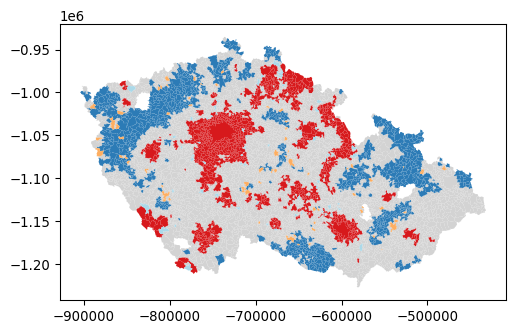

The map above displays the LISA results of the presidential elections.
In bright red, you find those municipalities with an unusual
concentration of high levels of Pavel’s voters also surrounded by high
levels of his voters. This corresponds with areas in the Prague
Metropolitan region, around other large cities like Pilsen or Brno and
some other areas. On the other hand, areas in the dark blue voted
against Pavel, similarly to their surrounding municipalities. In orange,
you find the first type of *spatial outliers*. These are areas with high
Pavel’s gain but surrounded by areas voting for Babiš (e.g. Mariánské
Lázně). Finally, in light blue, you find the other type of spatial
outlier: municipalities with low Pavel’s support surrounded by other
municipalities with high support.

The substantive interpretation of a LISA map needs to relate its output
to the original intention of the analyst who created the map. In this
case, your original idea was to explore the spatial structure of support
of Petr Pavel. The LISA proves a fairly useful tool in this context.
Comparing the LISA map above with the choropleth you started with, you
can interpret the LISA as a “simplification” of the detailed but perhaps
too complicated picture in the choropleth that focuses the reader’s
attention to the areas that display a particularly high concentration of
(dis)similar values, helping the spatial structure of the vote emerge
more explicitly. The result of this highlights the relevance that the
cities had in voting for Pavel, as well as the regions of the map where
there was a lot less excitement about him.

## Other options

Join counts and Moran’s methods are not the only ways of computing
spatial autocorrelation. `esda` offers way more, including [Geary’s
$C$](https://pysal.org/esda/generated/esda.Geary.html#esda.Geary),
[Getis-Ord $G$](https://pysal.org/esda/generated/esda.G.html#esda.G),
which can both be measured as global or local statistics, and other
methods, exposed in a similar way as those you have used today.

> **Additional reading**
>
> -   Have a look at the chapters [*Global Spatial
>     Autocorrelation*](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#)
>     and [*Local Spatial
>     Autocorrelation*](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)
>     from the Geographic Data Science with Python by @rey2023geographic
>     for more details and some other extensions.

# Clustering and regionalisation

This session is all about finding groups of similar observations in data
using clustering techniques.

Many questions and topics are complex phenomena that involve several
dimensions and are hard to summarise into a single variable. In
statistical terms, you call this family of problems *multivariate*, as
opposed to *univariate* cases where only a single variable is considered
in the analysis. Clustering tackles this kind of questions by reducing
their dimensionality -the number of relevant variables the analyst needs
to look at - and converting it into a more intuitive set of classes that
even non-technical audiences can look at and make sense of. For this
reason, it is widely used in applied contexts such as policymaking or
marketing. In addition, since these methods do not require many
preliminary assumptions about the structure of the data, it is a
commonly used exploratory tool, as it can quickly give clues about the
shape, form and content of a dataset.

The basic idea of statistical clustering is to summarise the information
contained in several variables by creating a relatively small number of
categories. Each observation in the dataset is then assigned to one, and
only one, category depending on its values for the variables originally
considered in the classification. If done correctly, the exercise
reduces the complexity of a multi-dimensional problem while retaining
all the meaningful information contained in the original dataset. This
is because once classified, the analyst only needs to look at in which
category every observation falls into, instead of considering the
multiple values associated with each of the variables and trying to
figure out how to put them together in a coherent sense. When the
clustering is performed on observations that represent areas, the
technique is often called geodemographic analysis.

Although there exist many techniques to statistically group observations
in a dataset, all of them are based on the premise of using a set of
attributes to define classes or categories of observations that are
similar *within* each of them, but differ *between* groups. How
similarity within groups and dissimilarity between them is defined and
how the classification algorithm is operationalised is what makes
techniques differ and also what makes each of them particularly well
suited for specific problems or types of data.

In the case of analysing spatial data, there is a subset of methods that
are of particular interest for many common cases in Spatial Data
Science. These are the so-called *regionalisation* techniques.
Regionalisation methods can also take many forms and faces but, at their
core, they all involve statistical clustering of observations with the
additional constraint that observations need to be geographical
neighbours to be in the same category. Because of this, rather than
category, you will use the term *area* for each observation and *region*
for each category, hence regionalisation, the construction of regions
from smaller areas.

The Python package you will use for clustering today is called
`scikit-learn` and can be imported as `sklearn`.

## Attribute-based clustering

In this session, you will be working with another dataset you should
already be familiar with - the Scottish Index of Multiple Deprivation.
This time, you will focus only on the area of Glasgow City prepared for
this course.

### Scottish Index of Multiple Deprivation

As always, the table can be read from the site:

In [ ]:
simd = gpd.read_file(
    "https://martinfleischmann.net/sds/clustering/data/glasgow_simd_2020.gpkg"
)

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/clustering/data/glasgow_simd_2020.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> simd = gpd.read_file(
>     "glasgow_simd_2020.gpkg",
> )
> ```

Inspect the structure of the table:

In [ ]:
simd.info()

Before you jump into exploring the data, one additional step that will
come in handy down the line. Not every variable in the table is an
attribute that you will want for the clustering. In particular, you are
interested in sub-ranks based on individual SIMD domains, so you will
only consider those. Hence, first manually write them so they are easier
to subset:

In [ ]:
subranks = [
    "IncRankv2",
    "EmpRank",
    "HlthRank",
    "EduRank",
    "GAccRank",
    "CrimeRank",
    "HouseRank"
]

You can quickly familiarise yourself with those variables by plotting a
few maps like the one below to build your intuition about what is going
to happen.

In [ ]:
simd[["IncRankv2", "geometry"]].explore("IncRankv2", tiles="CartoDB Positron", tooltip=False)

You can see a decent degree of spatial variation between different
sub-ranks. Even though you only have seven variables, it is very hard to
“mentally overlay” all of them to come up with an overall assessment of
the nature of each part of Glasgow. For bivariate correlations, a useful
tool is the correlation matrix plot, available in `seaborn`:

In [ ]:
_ = sns.pairplot(simd[subranks],height=1, plot_kws={"s":1})

This is helpful to consider uni and bivariate questions such as: *what
is the relationship between the ranks?* *Is health correlated with
income?* However, sometimes, this is not enough and you are interested
in more sophisticated questions that are truly multivariate and, in
these cases, the figure above cannot help us. For example, it is not
straightforward to answer questions like: *what are the main
characteristics of the South of Glasgow?* *What areas are similar to the
core of the city?* *Are the East and West of Glasgow similar in terms of
deprivation levels?* For these kinds of multi-dimensional questions
-involving multiple variables at the same time- you require a truly
multidimensional method like statistical clustering.

### K-Means

A cluster analysis involves the classification of the areas that make up
a geographical map into groups or categories of observations that are
similar within each other but different between them. The classification
is carried out using a statistical clustering algorithm that takes as
input a set of attributes and returns the group (“labels” in the
terminology) each observation belongs to. Depending on the particular
algorithm employed, additional parameters, such as the desired number of
clusters employed or more advanced tuning parameters (e.g. bandwith,
radius, etc.), also need to be entered as inputs. For your
classification of SIMD in Glasgow, you will start with one of the most
popular clustering algorithms: K-means. This technique only requires as
input the observation attributes and the final number of groups that you
want it to cluster the observations into. In your case, you will use
five to begin with as this will allow us to have a closer look into each
of them.

Although the underlying algorithm is not trivial, running K-means in
Python is streamlined thanks to `scikit-learn`. Similar to the extensive
set of available algorithms in the library, its computation is a matter
of two lines of code. First, you need to specify the parameters in the
`KMeans` method (which is part of `scikit-learn`’s `cluster` submodule).
Note that, at this point, you do not even need to pass the data:

In [ ]:
kmeans5 = cluster.KMeans(n_clusters=5, random_state=42)

This sets up an object that holds all the parameters required to run the
algorithm. To actually run the algorithm on the attributes, you need to
call the `fit` method in `kmeans5`:

In [ ]:
kmeans5.fit(simd[subranks])

The `kmeans5` object now contains several components that can be useful
for an analysis. For now, you will use the labels, which represent the
different categories in which you have grouped the data. Remember, in
Python, life starts at zero, so the group labels go from zero to four.
Labels can be extracted as follows:

In [ ]:
kmeans5.labels_

Each number represents a different category, so two observations with
the same number belong to the same group. The labels are returned in the
same order as the input attributes were passed in, which means you can
append them to the original table of data as an additional column:

In [ ]:
simd["kmeans_5"] = kmeans5.labels_
simd["kmeans_5"].head()

It is useful to display the categories created on a map to better
understand the classification you have just performed. For this, you
will use a unique values choropleth, which will automatically assign a
different colour to each category:

In [ ]:
simd[["kmeans_5", 'geometry']].explore("kmeans_5", categorical=True, tiles="CartoDB Positron")

The map above represents the geographical distribution of the five
categories created by the K-means algorithm. A quick glance shows a
strong spatial structure in the distribution of the colours: group 3
(grey) is mostly in central areas and towards the west, group 1 (green)
covers peripheries and so on, but not all clusters are equally
represented.

> **Not all data can go to clustering in their raw form**
>
> Clustering, as well as many other statistical methods, often depends
> on pairwise distances between observations based on the variables
> passed. That has, in practice, serious implications on what can be
> used. For example, you cannot use one variable that is limited to a
> range between 0 and 1 and another that stretches from 0 to 100 000.
> The latter would dominate the distance and the former would have
> negligible effect on the results. For these reasons, the data usually
> need to be standardised in some way. See the [*Data*
> section](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html#data)
> of the chapter [*Clustering and
> Regionalization*](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html)
> from the Geographic Data Science with Python by @rey2023geographic for
> more details.
>
> In this case, all the sub-ranks are defined the same way so you don’t
> need any standardisation.

### Exploring the nature of the categories

Once you have a sense of where and how the categories are distributed
over space, it is also useful to explore them statistically. This will
allow you to characterise them, giving you an idea of the kind of
observations subsumed into each of them. As a first step, find how many
observations are in each category. To do that, you will make use of the
`groupby` operator introduced before, combined with the function `size`,
which returns the number of elements in a subgroup:

In [ ]:
k5sizes = simd.groupby('kmeans_5').size()
k5sizes

The `groupby` operator groups a table (`DataFrame`) using the values in
the column provided (`kmeans_5`) and passes them onto the function
provided aftwerards, which in this case is `size`. Effectively, what
this does is to groupby the observations by the categories created and
count how many of them each contains. For a more visual representation
of the output, a bar plot is a good alternative:

In [ ]:
_ = k5sizes.plot.bar()

As you suspected from the map, groups vary in size, with group 2 having
over 200 observations, groups 0, 1 and 4 over 100 and a group 3 having
74 observations.

In order to describe the nature of each category, you can look at the
values of each of the attributes you have used to create them in the
first place. Remember you used the sub-ranks on many aspects of
deprivation to create the classification, so you can begin by checking
the average value of each. To do that in Python, you will rely on the
`groupby` operator which you will combine with the function `mean`:

In [ ]:
k5_means = simd.groupby('kmeans_5')[subranks].mean()
k5_means.T

When interpreting the values, remember that a lower value represents
higher deprivation. While the results seem plausible and there are ways
of interpreting them, you haven’t used any spatial methods.

## Spatially-lagged clustering

K-means (in its standard implementation) does not have a way of
including of spatial restriction. However, it is still a very powerful
and efficient algorithm and it would be a shame not to make a use of it
when dealing with spatial data. To include spatial dimension in (nearly
any) non-spatial model, you can use spatially lagged variables. Instead
of passing in only the variables observed in each data zone, you also
pass in their spatial lags. Due to the nature of the spatial lag, this
encodes a certain degree of spatial contiguity into data that are being
clustered, often resulting in spatially more homogenous areas.

Start with building a queen contiguity weights matrix.

In [ ]:
queen = graph.Graph.build_contiguity(simd)

As always, you will need a row-standardised matrix.

In [ ]:
queen_row = queen.transform("R")

You need a lagged version of each of the sub-ranks as its own, new
column. You can loop through the `subranks` list and create them one by
one, using a basic *for loop*.

In [ ]:
for column in subranks:
    simd[column + "_lag"] = queen_row.lag(simd[column])

You can check that the `simd` table now has new columns.

In [ ]:
simd.info()

Let’s create a list of these new columns.

In [ ]:
subranks_lag = [column + "_lag" for column in subranks]
subranks_lag

Now, combine the list of original variables and those with a lag to make
it easier to pass the data to K-means.

In [ ]:
subranks_spatial = subranks + subranks_lag
subranks_spatial

Initialise a new clustering model.

In [ ]:
kmeans5_lag = cluster.KMeans(n_clusters=5, random_state=42)

And run it using the new subset, adding lagged variables on top of the
original ones.

In [ ]:
kmeans5_lag.fit(simd[subranks_spatial])

Assing the result as a column.

In [ ]:
simd["kmeans_5_lagged"] = kmeans5_lag.labels_

And explore as a map.

In [ ]:
simd[["kmeans_5_lagged", 'geometry']].explore("kmeans_5_lagged", categorical=True, tiles="CartoDB Positron")

Comparing the spatially-lagged clusters with the original results shows
that the new clusters are much more homogenous spatially, delineating
relatively compact regions of data zones.

As you have seen, the essence of this approach is to group areas based
on a purely statistical basis: *where* each area is located is
irrelevant for the label it receives from the clustering algorithm. In
many contexts, this is not only permissible but even desirable, as the
interest is to see if particular combinations of values are distributed
over space in any discernible way. However, in other contexts, you may
be interested in creating groups of observations that follow certain
spatial constraints. For that, you now turn to regionalisation
techniques.

## Spatially-constrained clustering (regionalisation)

Regionalisation is the subset of clustering techniques that impose a
spatial constraint on the classification. In other words, the result of
a regionalisation algorithm contains areas that are spatially
contiguous. While spatially lagged clustering may result in contiguous
areas, it does not enforce them. Regionalisation does. Effectively, what
this means is that these techniques aggregate areas into a smaller set
of larger ones, called regions. In this context, then, areas are
*nested* within regions. Real-world examples of this phenomenon include
counties within states or, in Scotland, data zones (`DZName`) into Local
Authorities (`LAName`). The difference between those examples and the
output of a regionalisation algorithm is that while the former are
aggregated based on administrative principles, the latter follows a
statistical technique that, very much the same as in the standard
statistical clustering, groups together areas that are similar on the
basis of a set of attributes. Only now, such statistical clustering is
spatially constrained.

As in the non-spatial case, there are many different algorithms to
perform regionalization, and they all differ on details relating to the
way they measure (dis)similarity, the process to regionalize, etc.
However, same as above too, they all share a few common aspects. In
particular, they all take a set of input attributes *and* a
representation of space in the form of a binary spatial weights matrix.
Depending on the algorithm, they also require the desired number of
output regions into which the areas are aggregated.

To illustrate these concepts, you will run a regionalisation algorithm
on the SIMD data you have been using. In this case, the goal will be to
delineate regions of similar levels of deprivation. In this way, the
resulting regions will represent a consistent set of areas that are
similar to each other in terms of the SIMD sub-ranks received.

At this point, you have all the pieces needed to run a regionalisation
algorithm since you have already created a queen contiguity matrix
above. For this example, you will use a spatially-constrained version of
the agglomerative algorithm. This is a similar approach to that used
above (the inner workings of the algorithm are different, however) with
the difference that, in this case, observations can only be labelled in
the same group if they are spatial neighbours, as defined by your
spatial weights matrix `queen`. The way to interact with the algorithm
is very similar to that above. You first set the parameters:

In [ ]:
agg5 = cluster.AgglomerativeClustering(n_clusters=5, connectivity=queen.sparse)

And you can run the algorithm by calling `fit`:

In [ ]:
agg5.fit(simd[subranks])

And then you append the labels to the table in the same way as before:

In [ ]:
simd["agg_5"] = agg5.labels_

At this point, the column `agg_5` is no different than `kmeans_5`: a
categorical variable that can be mapped into a unique values choropleth.
In fact, the following code snippet is exactly the same as before, only
replacing the name of the variable to be mapped and the title:

In [ ]:
simd[["agg_5", 'geometry']].explore("agg_5", categorical=True, tiles="CartoDB Positron")

### Extracting the region boundaries

With this result, you may want to extract the boundaries of the regions,
rather than labels of individual data zones. To create the new
boundaries “properly”, you need to dissolve all the polygons in each
category into a single one. This is a standard GIS operation that is
supported by `geopandas`.

In [ ]:
simd_regions = simd[["agg_5", "geometry"]].dissolve("agg_5")
simd_regions

In [ ]:
simd_regions.reset_index().explore("agg_5", categorical=True, tiles="CartoDB Positron")

> **Additional reading**
>
> Have a look at the chapter [*Clustering and
> Regionalization*](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html)
> from the Geographic Data Science with Python by @rey2023geographic for
> more details and some other extensions.

## Acknowledgements

This material is taken from *Spatial Data Science for Social Geography* course by Martin Fleischmann, which is derived from *A Course on Geographic Data Science* by
Dani Arribas-Bel, licensed under CC-BY-SA 4.0. 
The code was updated
to use the new `libpysal.graph` module instead of `libpysal.weights`.
The text was slightly adapted to accommodate a different datasets, the
module change, and the inclusion of spatially lagged K-means.